# En notebook for å lage clustre fra kollokasjoner

Ord danner clustre via en kollokasjonsanalyse. Her litt engelsk forklaring:

The term collocation has traditionally been restricted to words that are juxtaposed together as phrases like “strong coffee”, “strict regime” or “eat dinner”. Here we take collocations to be realized as skipgrams, or as word pairs that simply cooccur within a context which in itself is a contiguous sequence of words, typically a paragraph or a window of n words around a given word. Juxtaposed collocates will also be part of the result set. 

The collocates for a word are those words that are associated with it based on a particular measure of association. Collocations can be viewed as discourse markers for a given word, in the sense that the collocates are deemed to have a special meaning when uttered (written or spoken) together with it, so that the word with its collocates constitute a complex sign. 



Start med å importere de kommandoene som trengs fra nbtext og graph_networkx_louvain. Den siste har funksjonalitet for å lage grafer fra clustre.

In [1]:
from module_update import update

Updated file nbtext.py
Updated file nbpictures.py


In [2]:
update('graph_networkx_louvain')

Updated file graph_networkx_louvain.py


In [3]:
import nbtext as nb
from nbtext import cloud, get_urn, Cluster, Corpus
import graph_networkx_louvain as gnl
%matplotlib inline

In [4]:
import imp
imp.reload(gnl)

<module 'graph_networkx_louvain' from 'C:\\Users\\larsj\\Documents\\NB_API_Python-master\\graph_networkx_louvain.py'>

### Definer et cluster for et ord over en gitt periode fra bøker eller aviser

In [71]:
mcluster = Cluster(
    'influensa', 
    period=(1990, 2000), 
    before=5, 
    after=5, 
    corpus='bok',
    reference=150, 
    word_samples=500)

# Inspiser clustre

Hvilke ord er knyttet til clustringsordet, er det variasjon i kontekst, trengs det mer data. Er resultatet tolkbart?

In [72]:
mcluster.cluster_set(top=50, exponent=1.001, aslist=False)

,influensa
har,1.991354
hadde,1.991164
med,1.991154
eller,1.990824
ikke,1.990343
forkjølelse,1.990324
mot,1.989573
Det,1.989417
kan,1.989362
fått,1.989306


In [73]:
mcluster.search_words('Herre Kristus Pilatus bønn katekisme . , ; : og i på',exponent=1.01)

,influensa
bønn,1.789743
;,1.552265
på,1.461452
:,0.641840
og,0.445120
",",0.442904
.,0.323291
i,0.223236


# Tegn en ordsky


kommandoen for å tegne en ordsky er *cloud()*. Argumentet kan være mange ting, så lenge det kobler et ord til et tall. Datarammer som består av en kolonne fungerer fint.

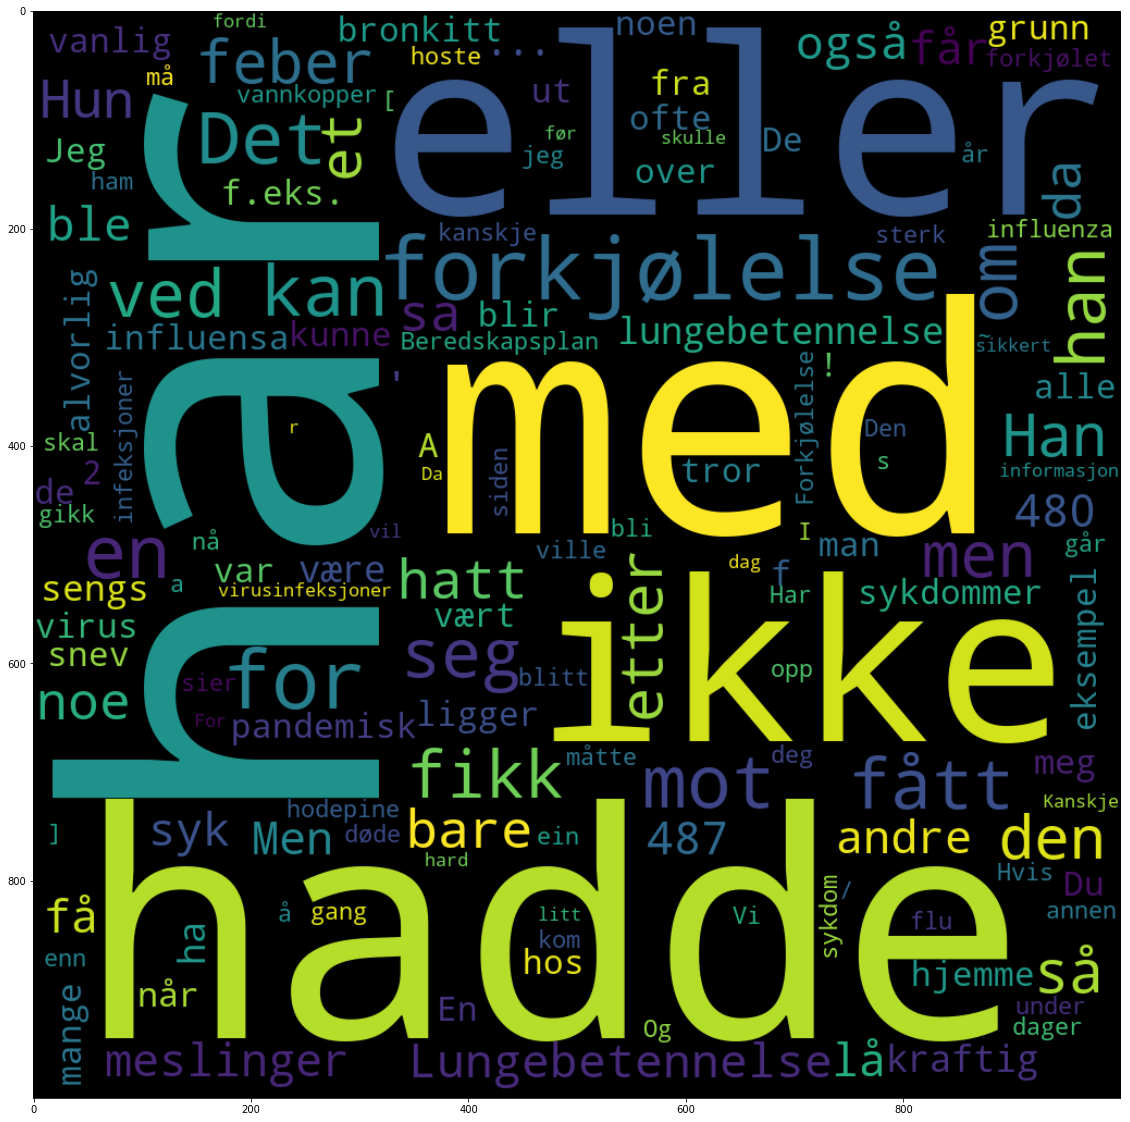

In [74]:
nb.cloud(mcluster.cluster_set(aslist=False)[:150], background='black')

### Informasjon om Dewey-systemet
Sjekk ut [Webdewey](http://deweysearchno.pansoft.de/webdeweysearch/index.html), for å se klassifikasjonssystemet.

*cutdown()* brukes for å begrense grafer.

In [5]:
cutdown = lambda x: x.subgraph([n[0] for n in x.degree() if n[1]>1])

### Lager korpuset med *get_urn()*

Her velger vi et bestemt antall bøker fra en deweyklasse.

In [74]:
korpus = nb.get_urn({'subject':'Infeksjoner', 'limit':20, 'lang':'nob', 'year':1960, 'next':50})
korpus

[[2008060404020, 'Leach, Penelope', 'Barnet fra A til Å', 1986],
 [2008110400126, 'Hovig, Berit', 'Infeksjonssykdommer', 2001],
 [2008031000055, 'Beeching, Nick J.', 'Infeksjonssykdommer', 1995],
 [2016030408098, 'Berg, Egil Weie', 'Næringsmiddelassosiert sykdom', 1996],
 [2013102406097, 'Juvkam, Kari Hilde', 'Gynekologi', 2008],
 [2014021806171, '', 'Pasienten med nedsatt infeksjonsforsvar', 1979],
 [2007080701036, 'Frøland, Stig', 'AIDS', 1986],
 [2012070605026, '', 'Mikrober, helse og sykdom', 2009],
 [2011070108093, '', 'Blodprøvetaking i praksis', 2005],
 [2011070406189, 'Nøkleby, Kjell A.', 'Fotlidelser', 2004],
 [2011071906039, '', 'Nasjonal veileder for håndhygiene', 2004],
 [2008031200044, 'Josephsen, Joh. O.', 'Mikroorganismer og sykdom', 1995],
 [2009013004083, 'Schøyen, Rolf', 'Mikroorganismer og sykdom', 2002],
 [2009102600019, 'Blystad, Hans', 'Infeksjonssykdommer i Norge', 1995],
 [2008020604084, '', 'Medisinsk mikrobiologi', 1994],
 [2009061000006,
  'Moi, Harald',
  'S

## Lag et nettverk basert på kaskade av kollokasjoner

Vi starter med et ord, og finner alle kollokasjonene for det. For hvert ord i blandt de beste kollokasjonsordene, lages en ny kollokasjon basert på samme korpus.

Kommandoen `make_collocation()` tar parametret `urns`, som typisk vil være resultatet av en `get_urn()`, der `cutoff`sier hvor høy frekvens ord i korpuset skal ha for å telle med, noe som gjør at en unngår spesielle ord (OCR-feil og annet). Parametret `top` forteller hvor mange ord fra hver kollokasjon som skal være med.

In [87]:
nb.get_urnkonk('influensa', {'urns':korpus, 'size':20})

"Barnet fra A til Å, Leach, Penelope, 1986",gang dør av komplikasjoner etter,influensa,.
"Barnet fra A til Å, Leach, Penelope, 1986","til å få forskjellige infeksjonssykdommer,",influensa,og nå og da magebesvær
"Barnet fra A til Å, Leach, Penelope, 1986","de som forårsaker forkjølelse ,",influensa,"og meslinger , nyses eller"
"Barnet fra A til Å, Leach, Penelope, 1986",som ved generelle virus-sykdommer som,influensa,", oppstår det symptomer som"
"Barnet fra A til Å, Leach, Penelope, 1986","bare polio , men også",influensa,og nesten alle generelle virussykdommer
"Barnet fra A til Å, Leach, Penelope, 1986",For mange mennesker er «,influensa,» en samlebenevnelse for enhver
"Barnet fra A til Å, Leach, Penelope, 1986",fra at pasienten har «,influensa,» . Men mange virusarter
"Barnet fra A til Å, Leach, Penelope, 1986",Om vinteren forekommer ofte ekte,influensa,fremkalt av et ekte influensavirus.
"Barnet fra A til Å, Leach, Penelope, 1986",None,influensa,None
"Barnet fra A til Å, Leach, Penelope, 1986",Rekonvalesens etter,influensa,None
"Barnet fra A til Å, Leach, Penelope, 1986",Komplikasjoner ved,influensa,None


In [89]:
data = gnl.make_collocation_graph('influensa', urns=korpus, cutoff=25, top=30)

In [90]:
# data er en graf, tilsvarende graf uten løvnoder får vi ved å benytte cutdown
data_cut = cutdown(data)

## Graf uten løvnoder (bruk cutdown)

Grafen tegnes med en fargelegging av nodene. Noder med samme farge tilhører samme louvain-cluster. Ellers vil grupperingen passe til klikk-strukturen.

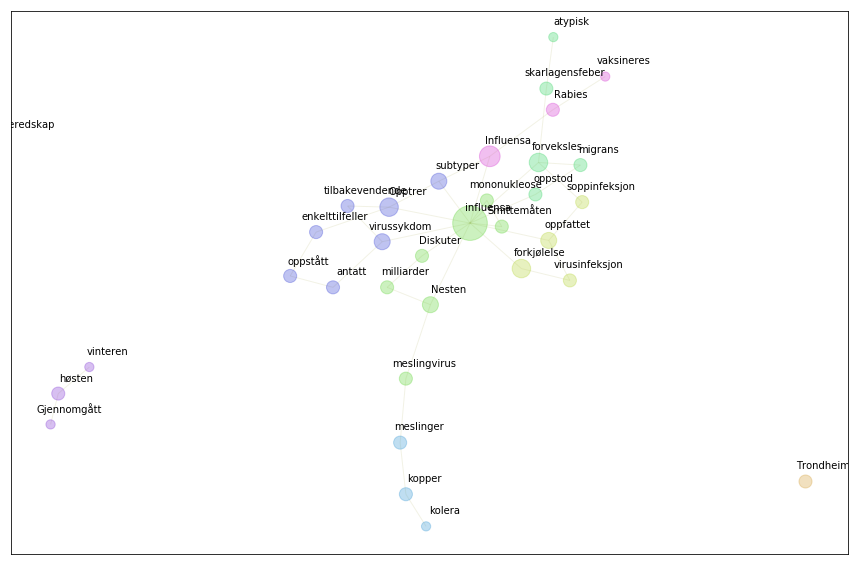

In [91]:
gnl.show_graph(data_cut)

In [92]:
gnl.show_cliques(data)

(3, 1) Smittemåten, influensa, mononukleose

(3, 2) subtyper, Influensa, influensa, Opptrer



In [93]:
gnl.show_community(data_cut)

1 forkjølelse, soppinfeksjon, oppfattet, virusinfeksjon

2 milliarder, influensa, meslingvirus, Nesten, mononukleose, Smittemåten, Diskuter

3 skarlagensfeber, migrans, forveksles, oppstod, atypisk

4 Midlene

5 kopper, kolera, meslinger

6 tilbakevendende, enkelttilfeller, subtyper, antatt, virussykdom, oppstått, Opptrer

7 vinteren, Gjennomgått, høsten

8 Influensa, vaksineres, Rabies

9 etc

10 beredskap

11 Trondheim



In [94]:
gnl.show_community(data)

1 lepra, conjunctiva, smitteførende, prevensjon, dråpesmitte, influensa, induksjon, undergrupper, tallene, likne, epitelcellene, harmløse, intrauterin, infeksiøs, mononukleose, Smittemåten, menneskers, sæd, øyeinfeksjon, kontaktsmitte

2 avgjøre, utelukkende, mild, står, moderat, formeringen, virussykdom, bakgrunnen, dagers, transkriptase, primært, smittsom, godartet

3 varianter, spredte, årene, prøvetakingen, liv, penicillinresistente, oppstod, homofile, bittstedet, unge, oppfatning, akseptert, epidemi

4 virusinfeksjon, alminnelig, ordentlig, Influensavirus, bronkitt, rhinovirus, fosterskade, forkjølelse, Spedbarn, vanlig, lei, virussykdommer, Voksne

5 Undersøkelser, influensavirus, Kikhoste, snakke, isolerte, differensiering, mcd, baserer, Videre, Influensa, data, epidemier, Rabies, subtyper, epidemiologiske, verdifulle, angitt, virulente, fire, eksotoksiner, overvåkes

6 tilbakevendende, erythema, stress, primærinfeksjon, sporadiske, mildere, infectiosum, mere, persisterende, Opp

## Grafen uten kutt - alle løvnodene er med

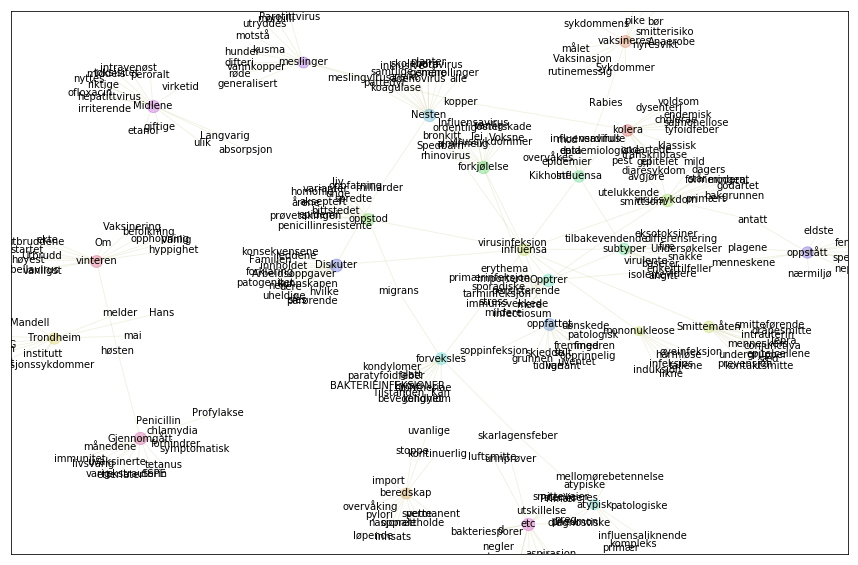

In [95]:
gnl.show_graph(data, deltax=0, deltay=0, spread=0.12)

In [96]:
nb.central_betweenness_characters(data_cut, n=20)

[('influensa', 0.5192717086834734),
 ('Nesten', 0.17983193277310924),
 ('forveksles', 0.12733893557422968),
 ('meslingvirus', 0.12605042016806722),
 ('Influensa', 0.08739495798319329),
 ('meslinger', 0.08739495798319329),
 ('Opptrer', 0.08431372549019607),
 ('virussykdom', 0.07759103641456584),
 ('skarlagensfeber', 0.04537815126050421),
 ('kopper', 0.04537815126050421),
 ('Rabies', 0.04537815126050421),
 ('oppfattet', 0.04218487394957983),
 ('enkelttilfeller', 0.024089635854341738),
 ('antatt', 0.020728291316526606),
 ('forkjølelse', 0.02),
 ('oppstod', 0.018879551820728292),
 ('Diskuter', 0.018487394957983194),
 ('subtyper', 0.008403361344537815),
 ('soppinfeksjon', 0.005098039215686275),
 ('milliarder', 0.004201680672268908)]

In [97]:
nb.central_characters(data_cut, n=20)

[('influensa', 0.39999999999999997),
 ('Influensa', 0.14285714285714285),
 ('forveksles', 0.11428571428571428),
 ('forkjølelse', 0.11428571428571428),
 ('Opptrer', 0.11428571428571428),
 ('oppfattet', 0.08571428571428572),
 ('virussykdom', 0.08571428571428572),
 ('Nesten', 0.08571428571428572),
 ('subtyper', 0.08571428571428572),
 ('soppinfeksjon', 0.05714285714285714),
 ('skarlagensfeber', 0.05714285714285714),
 ('kopper', 0.05714285714285714),
 ('antatt', 0.05714285714285714),
 ('meslingvirus', 0.05714285714285714),
 ('oppstod', 0.05714285714285714),
 ('migrans', 0.05714285714285714),
 ('mononukleose', 0.05714285714285714),
 ('oppstått', 0.05714285714285714),
 ('tilbakevendende', 0.05714285714285714),
 ('enkelttilfeller', 0.05714285714285714)]

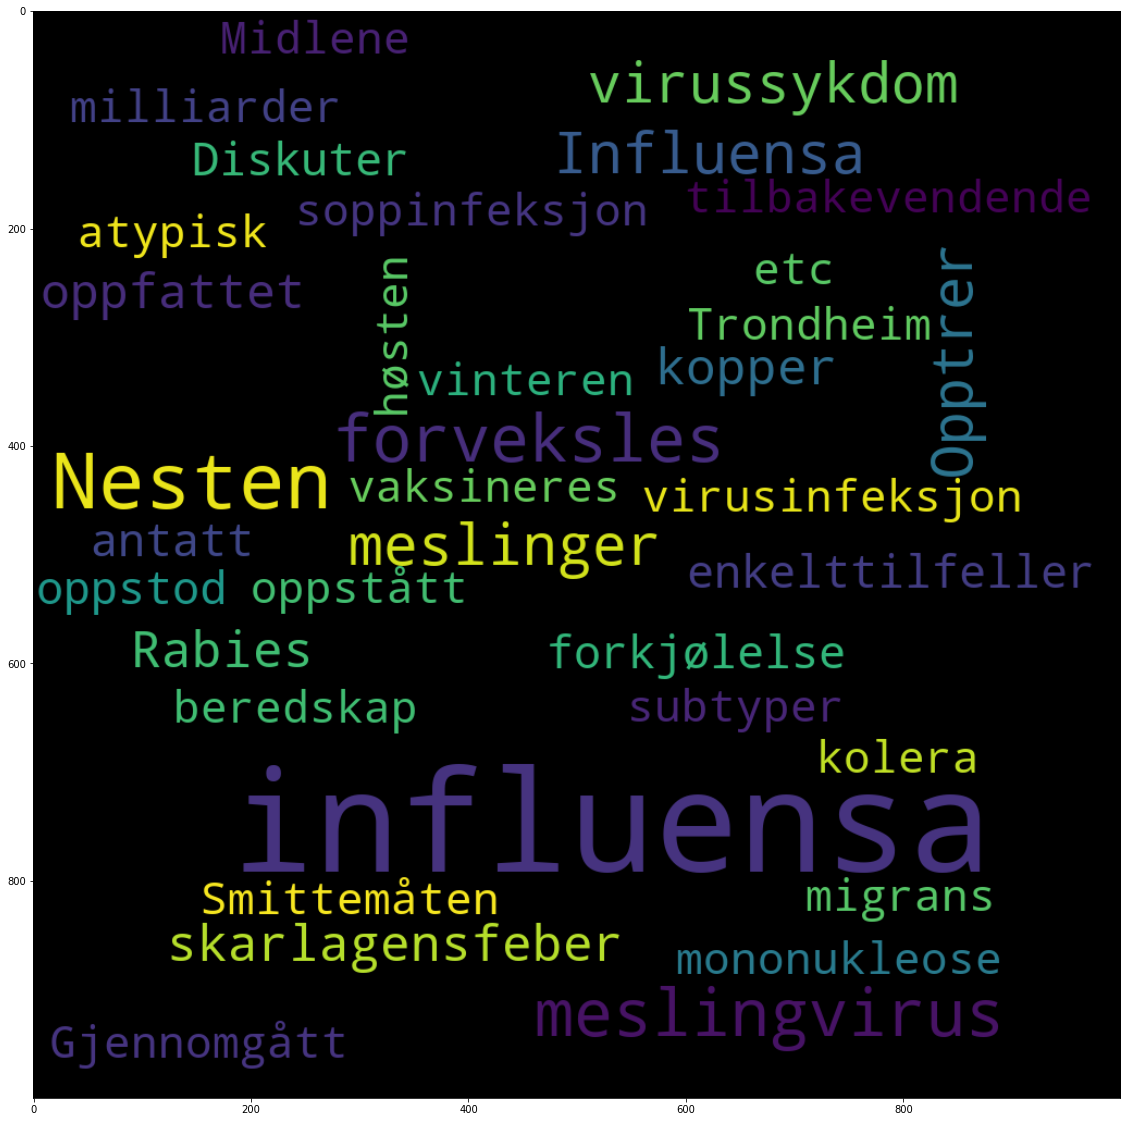

In [98]:
nb.cloud(nb.frame(dict(nb.central_betweenness_characters(data_cut, n=50)),'f'))

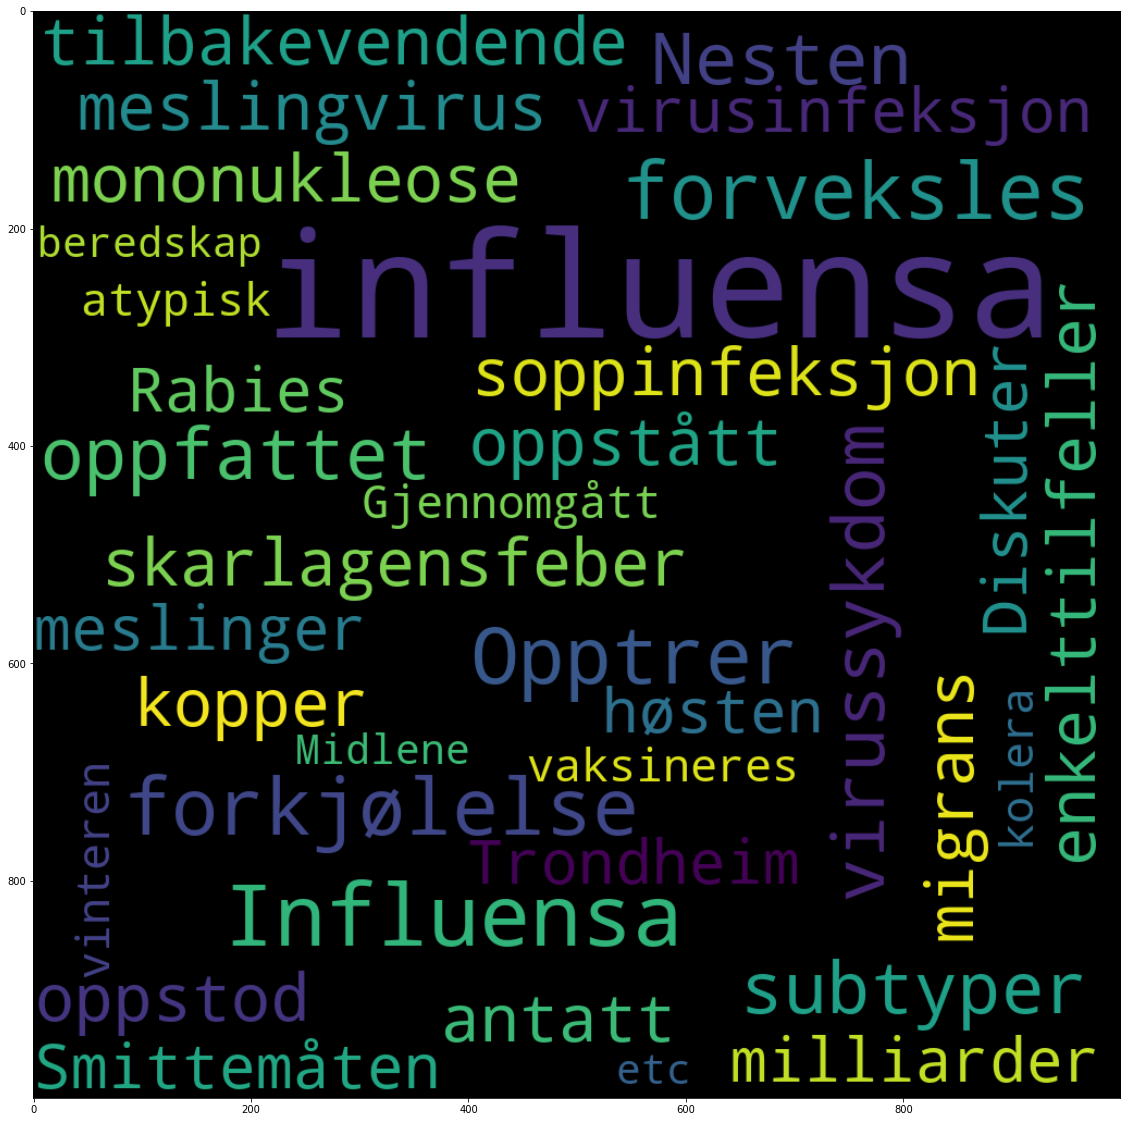

In [99]:
nb.cloud(nb.frame(dict(nb.central_characters(data_cut, n=50)),'f'))

### Sammenlign med koordinasjonsnettverket

In [106]:
influensa = nb.make_graph('influensa, tuberkulose')

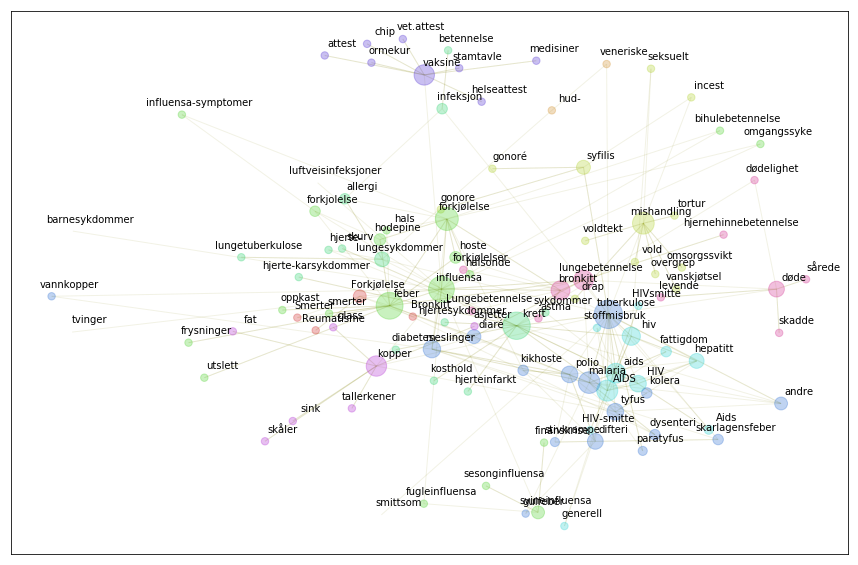

In [108]:
gnl.show_graph(influensa, spread=1)

In [111]:
nb.central_betweenness_characters(influensa, n=20)

[('tuberkulose', 0.2378296380513185),
 ('influensa', 0.13392396088008757),
 ('kreft', 0.1180077665159949),
 ('malaria', 0.11024217768325852),
 ('feber', 0.09336764028708364),
 ('lungebetennelse', 0.08523475093941027),
 ('forkjølelse', 0.06310553102643039),
 ('meslinger', 0.05935908650839349),
 ('mishandling', 0.05317728164301373),
 ('kopper', 0.049844236760124616),
 ('AIDS', 0.04915538186419489),
 ('vaksine', 0.047248182762201454),
 ('bronkitt', 0.0439661380406448),
 ('lungesykdommer', 0.041865333975248636),
 ('polio', 0.03459030993428709),
 ('allergi', 0.03117662423793628),
 ('aids', 0.03096658487217881),
 ('syfilis', 0.030330564209068885),
 ('infeksjon', 0.02342055529095576),
 ('tyfus', 0.022758423107535945)]

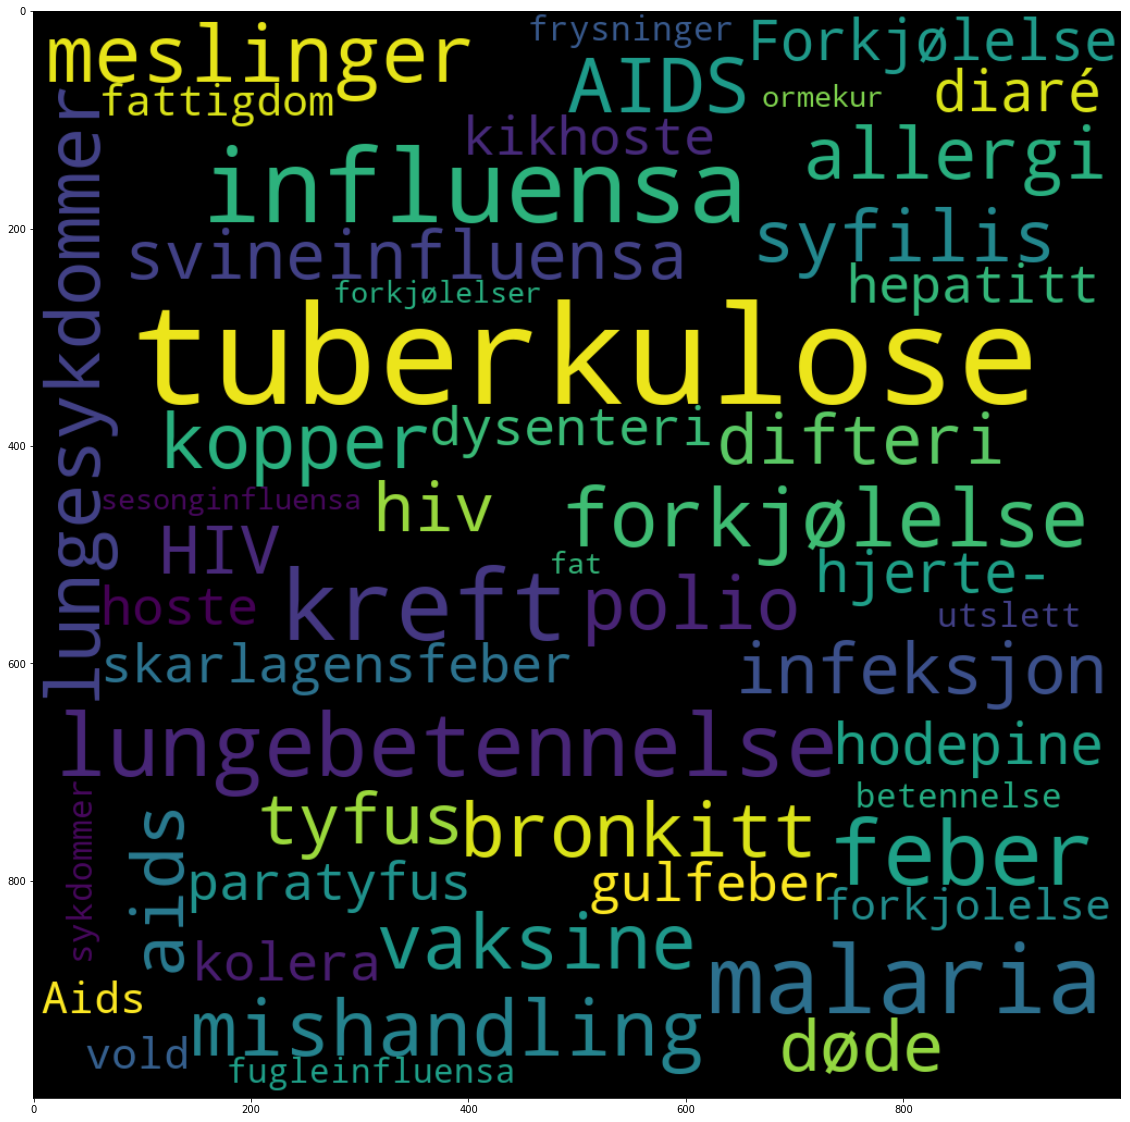

In [113]:
nb.cloud(nb.frame(dict(nb.central_betweenness_characters(influensa, n=50)),'k'))